# 1. Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD # Importation de TruncatedSVD
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from bs4 import BeautifulSoup
from collections import Counter

# 2. Data

In [2]:
data = pd.read_csv('sample-data.csv')
data.head()

,id,description
0,1,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an..."


In [3]:
data.describe(include='all')

,id,description
count,500.000000,500
unique,NaN,500
top,NaN,Active classic boxers - There's a reason why o...
freq,NaN,1
mean,250.500000,NaN
std,144.481833,NaN
min,1.000000,NaN
25%,125.750000,NaN
50%,250.500000,NaN
75%,375.250000,NaN


# PART I : Groups of products with similar descriptions

Objective :
- train a **clustering model** that will create groups of products for which the descriptions are "close" to each other. (10-20 clusters and not too many outliers)
- display a `wordcloud` for each cluster to analyze the results and see if the groups contain different words.

## 1 - Clean text

### 1.1 - Extract useful part of text

In [4]:
# récupérer la 1ère partie de la description (le nom du produit)
def extract(text):
    parts = text.split(" - ", 1)
    return parts[0]

data['title'] = data['description'].apply(extract)
data['part_description'] = data['description']
data.head()

,id,description,title,part_description
0,1,Active classic boxers - There's a reason why o...,Active classic boxers,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...,Active sport boxer briefs,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...,Active sport briefs,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc...",Alpine guide pants,"Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an...",Alpine wind jkt,"Alpine wind jkt - On high ridges, steep ice an..."


### 1.2 - 1rst lemmatization

In [5]:
nlp = spacy.load("en_core_web_sm")

# Fonction to lemmatize
def lemmatize_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_punct and not token.is_space]
    return " ".join(lemmas)

data['part_description_cleaned'] = data['part_description'].apply(lemmatize_text)

### 1.3 - Cleaning html, junkyard, numbers, ponctuation/specials caracters, stopwords

In [6]:
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text(separator = " ") # Supprimer les balises html

    text = text.lower() # lowercase
    text = re.sub(r'\d+', '', text) # Delete numbers
    text = re.sub(r'[^\w\s]', '', text) # Delete ponctuation/specials caracters
    text = re.sub(r'\s+', ' ', text).strip() # Delete spaces
    
    words = text.split()
    words = [word for word in words if word not in STOP_WORDS and len(word) >2] # Delete stopwords & 1 letter words
    return " ".join(words)

data['part_description_cleaned'] = data['part_description_cleaned'].apply(clean_text)

### 1.4 - 2ncd lemmatization

In [7]:
data['part_description_cleaned'] = data['part_description_cleaned'].apply(lemmatize_text)

### 1.5 - un/common words

In [8]:
# retrieve words that are present less than 50% of the time and more than 1% of the time
cv = CountVectorizer(min_df=.01, max_df=.33)
X = cv.fit_transform(data['part_description_cleaned'])
un_common_words = set(cv.get_feature_names_out())

# retrieve the list of all words present in the corpus
temp_cv = CountVectorizer(min_df=1, max_df=1.0)
temp_cv.fit_transform(data['part_description_cleaned'])
all_unique_words = set(temp_cv.get_feature_names_out())

# display words which are not keeped
excluded_words = all_unique_words - un_common_words
print(excluded_words)

# function to keep the word in the un_common list
def un_common(text):
    words = text.split()
    words = [word for word in words if word in un_common_words]
    return " ".join(words)

data['part_description_cleaned'] = data['part_description_cleaned'].apply(un_common)

{'blossom', 'facilitate', 'aesthetic', 'harbor', 'crushable', 'absorb', 'lizip', 'corrosion', 'entertainment', 'envelope', 'lake', 'marlwalker', 'birdwalk', 'calf', 'chart', 'highwater', 'dolphin', 'reputation', 'backward', 'bed', 'mid', 'bend', 'liphoto', 'require', 'stocking', 'universal', 'loss', 'sanity', 'recreate', 'junction', 'try', 'brutal', 'importance', 'bicycle', 'panty', 'listand', 'jetty', 'dimensions', 'glass', 'blouse', 'national', 'glassy', 'rugged', 'scottish', 'wraparound', 'absorption', 'dependent', 'disguise', 'munn', 'lirecycle', 'command', 'linotche', 'pitfall', 'immortal', 'bronze', 'bath', 'guilt', 'modular', 'practice', 'fair', 'depend', 'flourish', 'slough', 'hearty', 'charge', 'sunscreen', 'angst', 'asset', 'burrito', 'confuse', 'toad', 'geometry', 'gift', 'moment', 'shine', 'dorsal', 'waystretch', 'midtorso', 'charm', 'parent', 'vastly', 'baja', 'ranger', 'fasten', 'nicely', 'arete', 'fresh', 'raw', 'wickedly', 'scrape', 'parka', 'guanaco', 'hotel', 'mahalo'

In [9]:
data.head()

,id,description,title,part_description,part_description_cleaned
0,1,Active classic boxers - There's a reason why o...,Active classic boxers,Active classic boxers - There's a reason why o...,active classic boxer boxer favorite cool stick...
1,2,Active sport boxer briefs - Skinning up Glory ...,Active sport boxer briefs,Active sport boxer briefs - Skinning up Glory ...,active sport boxer brief skin glory movement b...
2,3,Active sport briefs - These superbreathable no...,Active sport briefs,Active sport briefs - These superbreathable no...,active sport brief fly brief minimalist choice...
3,4,"Alpine guide pants - Skin in, climb ice, switc...",Alpine guide pants,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pant skin climb ice rock traverse...
4,5,"Alpine wind jkt - On high ridges, steep ice an...",Alpine wind jkt,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt high ridge ice alpine jacket s...


### 1.6 - Stats

Nombre total de mots dans le corpus : 34552
Nombre de mots uniques dans le corpus : 1066

--------------------------------------------------



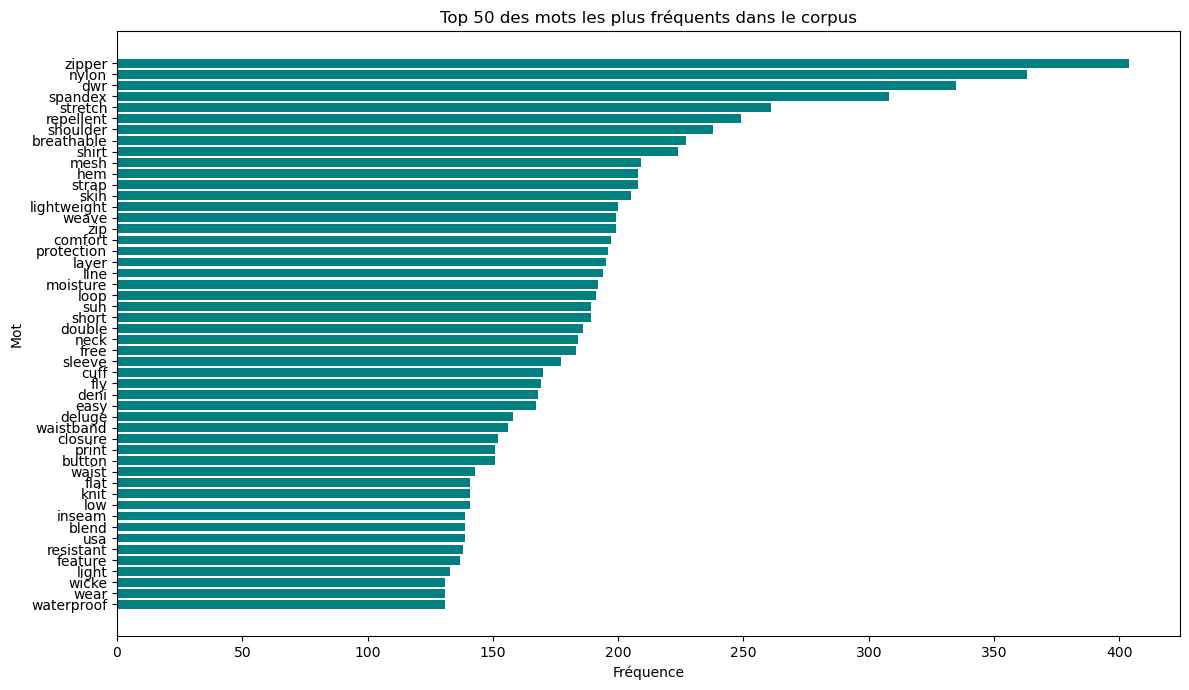

In [10]:
# Merge all lines of text into one large string
all_text = " ".join(data['part_description_cleaned'])

# Tokenize the merged text
all_tokens = all_text.split()

print(f"Nombre total de mots dans le corpus : {len(all_tokens)}")
print(f"Nombre de mots uniques dans le corpus : {len(set(all_tokens))}")
print("\n" + "-"*50 + "\n")

# Calculate word frequency
word_counts = Counter(all_tokens)

# Visualization of the 50 most frequent words (histogram)
most_common_words = word_counts.most_common(50)
words = [word[0] for word in most_common_words]
counts = [word[1] for word in most_common_words]

plt.figure(figsize=(12, 7))
plt.barh(words[::-1], counts[::-1], color='teal')
plt.xlabel('Fréquence')
plt.ylabel('Mot')
plt.title('Top 50 des mots les plus fréquents dans le corpus')
plt.tight_layout()
plt.show()


## 2 - Vectorizing text with TF-IDF

In [11]:
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(data['part_description_cleaned'])

print(f"Forme des données TF-IDF : {X_tfidf.shape}")

Forme des données TF-IDF : (500, 1061)


## 3 - DBSCAN

### 3.1 - Search for optimum parameters

In [12]:
results_1020_SVD = []

# Loops over different eps and min_samples
for eps in np.arange(0.01, 1, 0.01):
    for min_samples in range(3, 21):
        db = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine", algorithm='brute')
        labels = db.fit_predict(X_tfidf)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # filter to have number of clusters between 10 and 20
        if 10 <= n_clusters <= 20:
            data['cluster'] = db.labels_
            max_item =max(data['cluster'].value_counts())

            # filter to have less than 150 items max by cluster
            if max_item <150:
                results_1020_SVD.append({'eps': eps, 'min_samp' : min_samples, 'n_clusters': n_clusters, 'max_item' : max_item})

results_1020_SVD_pd = pd.DataFrame(results_1020_SVD, columns=['eps', 'min_samp', 'n_clusters','max_item'])
results_1020_SVD_pd = results_1020_SVD_pd.sort_values(by="max_item",)
results_1020_SVD_pd.head()

,eps,min_samp,n_clusters,max_item
7,0.66,8,11,126
1,0.63,6,17,130
0,0.63,5,18,136
3,0.64,6,15,136
2,0.64,5,18,140


In [13]:
# Select best values for parameters

eps_value = round(results_1020_SVD_pd.iloc[0]['eps'], ndigits=3)
min_samp_value = int(results_1020_SVD_pd.iloc[0]['min_samp'])
n_cluster_value = int(results_1020_SVD_pd.iloc[0]['n_clusters'])
print("eps value is : ",eps_value)
print("min_samp value is : ",min_samp_value)
print("nb of clusters is : ",n_cluster_value)

eps value is :  0.66
min_samp value is :  8
nb of clusters is :  11


### 3.2 - DBSCAN

In [14]:
# Instanciate DBSCAN
db = DBSCAN(eps=eps_value, min_samples=min_samp_value, metric="cosine", algorithm='brute')

db.fit(X_tfidf)
data['cluster'] = db.labels_

print(data['cluster'].value_counts())

cluster
-1     126
 0     126
 4      61
 3      52
 1      29
 6      24
 9      20
 2      18
 10     18
 7       9
 8       9
 5       8
Name: count, dtype: int64


## 4 - Wordclouds

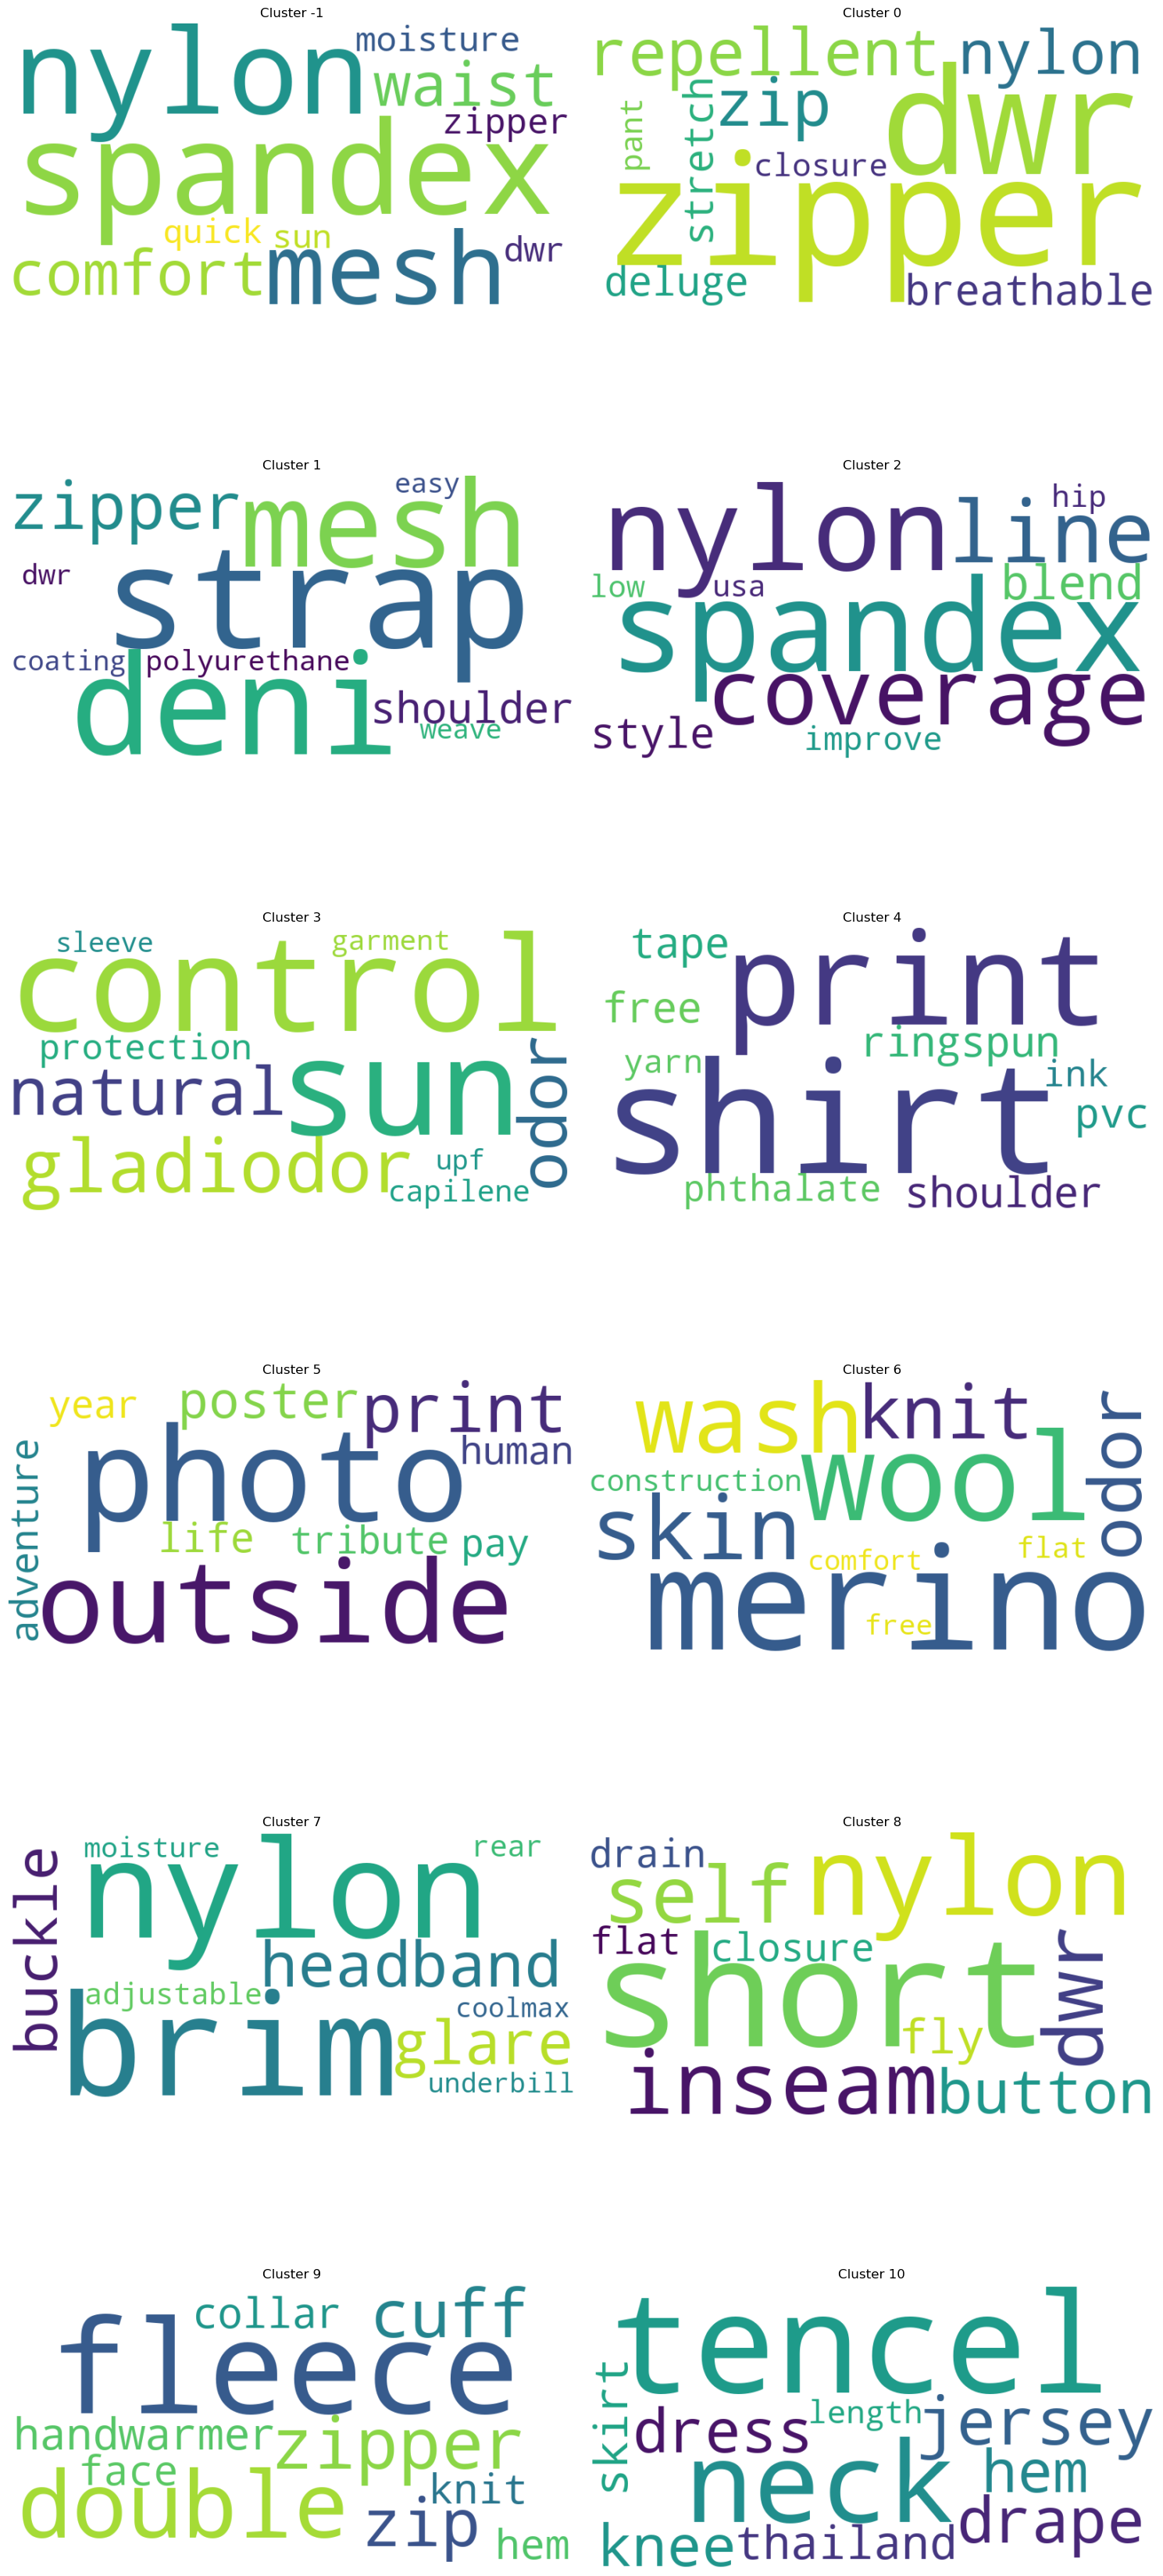

In [15]:
unique_clusters = data['cluster'].unique()

# select number of words to display on each wordcloud
max_words=10

if len(unique_clusters) == 0:
    print("Aucun cluster identifié (seulement du bruit ou 1 seul cluster). Ajustez les paramètres DBSCAN.")
else:
    cols = 2 if len(unique_clusters) > 1 else 1
    rows = (len(unique_clusters) + cols - 1) // cols

    plt.figure(figsize=(15, rows * 6))

    for i, cluster_id in enumerate(sorted(unique_clusters)):
        cluster_texts = " ".join(data[data['cluster'] == cluster_id]['part_description_cleaned'])

        if cluster_texts:
            wordcloud = WordCloud(width=800, height=400, background_color='white',
                                  max_words=max_words, contour_color='steelblue',
                                  collocations=False).generate(cluster_texts)

            plt.subplot(rows, cols, i + 1)
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.title(f'Cluster {cluster_id}')
            plt.axis('off')
        else:
            print(f"Pas de texte suffisant pour le cluster {cluster_id} après nettoyage ou cluster vide.")

    plt.tight_layout()
    plt.show()

# PART II : Recommender system

In [16]:
# Function to find similar item id
def find_similar_items(id_input):
    article_title = data[data['id'] == id_input]['title'].iloc[0]
    cluster_id_input = data[data['id'] == id_input]['cluster'].iloc[0]
    
    print("You are trying to find a similar article to article number", 
          id_input, 
          ":", 
          article_title, 
          "... Cluster number :", 
          cluster_id_input)
    
    # Select all IDs from the same cluster
    similar_items = data[data['cluster'] == cluster_id_input]['id']

    # Filter the list to REMOVE the entry ID from the proposition
    id_list_filtered = similar_items[similar_items != id_input]
    
    # Reset the index to ensure .iloc[i] works correctly
    id_list_final = id_list_filtered.reset_index(drop=True)

    # Select 5 items
    final_recommendations = id_list_final.iloc[0:5]
    
    print("\nThis is 5 similar articles :")
    
    for rec_id in final_recommendations:
        rec_title = data[data['id'] == rec_id]['title'].iloc[0]
        rec_cluster = data[data['id'] == rec_id]['cluster'].iloc[0]
        
        print("- Article number", 
              rec_id, 
              ":", 
              rec_title, 
              "... Cluster number :", 
              rec_cluster)
              
    print("Hope this helped !")
    return

In [17]:
# While loop to ask user to enter a number between 1 and 500
# Message error and keep asking if entry not well formated
while True :
    id_input = input("Enter an id to look for similar items. (Should be a number between 1 and 500)")

    try:
        val = int(id_input)
        if 1 <= val <= 500:
            # If entry well formated, execute function to find similar items
            find_similar_items(val)
            break
        else:
            print("Not between 1 and 500. Try again.")

    except ValueError:
        print('Not a number id. Try again.')

Not between 1 and 500. Try again.
Not a number id. Try again.
You are trying to find a similar article to article number 125 : S/s island hopper shirt ... Cluster number : -1

This is 5 similar articles :
- Article number 2 : Active sport boxer briefs ... Cluster number : -1
- Article number 3 : Active sport briefs ... Cluster number : -1
- Article number 9 : Baby micro d-luxe cardigan ... Cluster number : -1
- Article number 10 : Baby sun bucket hat ... Cluster number : -1
- Article number 11 : Baby sunshade top ... Cluster number : -1
Hope this helped !


# PART III : Topic modeling

## 1 - Clean text

In [18]:
# Function to split text when "<br>" appears and keep first part
def extract(text):
    parts = text.split("<br>", 1)
    return parts[0]

#Apply split function
data['long_part_description'] = data['description'].apply(extract)

# Apply clean_text function
data['long_part_description_cleaned'] = data['long_part_description'].apply(clean_text)

# Apply lemmatize function
data['long_part_description_cleaned'] = data['long_part_description_cleaned'].apply(lemmatize_text)

data.head()

,id,description,title,part_description,part_description_cleaned,cluster,long_part_description,long_part_description_cleaned
0,1,Active classic boxers - There's a reason why o...,Active classic boxers,Active classic boxers - There's a reason why o...,active classic boxer boxer favorite cool stick...,3,Active classic boxers - There's a reason why o...,active classic boxer there s reason boxer cult...
1,2,Active sport boxer briefs - Skinning up Glory ...,Active sport boxer briefs,Active sport boxer briefs - Skinning up Glory ...,active sport boxer brief skin glory movement b...,-1,Active sport boxer briefs - Skinning up Glory ...,active sport boxer brief skin glory require mo...
2,3,Active sport briefs - These superbreathable no...,Active sport briefs,Active sport briefs - These superbreathable no...,active sport brief fly brief minimalist choice...,-1,Active sport briefs - These superbreathable no...,active sport brief superbreathable nofly brief...
3,4,"Alpine guide pants - Skin in, climb ice, switc...",Alpine guide pants,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pant skin climb ice rock traverse...,0,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pant skin climb ice switch rock t...
4,5,"Alpine wind jkt - On high ridges, steep ice an...",Alpine wind jkt,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt high ridge ice alpine jacket s...,0,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt high ridge steep ice alpine ja...


**Search for duplicates + un/common words**   
We don't want the TFIDF matrix to be impacted if we remove duplicates within the same document, so we'll search for un/common words in a version without these duplicates.

Then we'll remove the un/common words in the version that still has the duplicates.

In [19]:
# function to clean duplicates
def doublon(text):
    words = text.split()
    unique_words_set = set(words)
    cleaned_text_unordered = " ".join(unique_words_set)
    return cleaned_text_unordered

data['long_part_description_cleaned_sansdouble'] = data['long_part_description_cleaned'].apply(doublon)

# Search for un/common words in the version without duplicates
cv = CountVectorizer(max_df=.33, min_df=.01)
X = cv.fit_transform(data['long_part_description_cleaned_sansdouble'])
un_common_words = cv.get_feature_names_out()

# Apply un_common function
data['long_part_description_cleaned'] = data['long_part_description_cleaned'].apply(un_common)
data['long_part_description_cleaned'].head()

0    active classic boxer there boxer favorite cool...
1    active sport boxer brief skin glory movement b...
2    active sport brief brief minimalist choice end...
3    alpine guide pant skin climb ice rock traverse...
4    alpine wind jkt high ridge ice alpine jacket s...
Name: long_part_description_cleaned, dtype: object

## 2 - Vectorizing text with TF-IDF

In [20]:
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf_topic = vectorizer.fit_transform(data['long_part_description_cleaned'])

print(f"Forme des données TF-IDF : {X_tfidf_topic.shape}")

Forme des données TF-IDF : (500, 896)


## 3 - TruncatedSVD

In [21]:
n_components = (n_cluster_value+1)

# SVD represent documents and terms in vectors
svd_model = TruncatedSVD(n_components=n_components, n_iter=100, random_state=42)

# LSA is the new matrix where each document is represented by a score on each subjet
lsa = svd_model.fit_transform(X_tfidf_topic)

components = svd_model.components_

# Retrieves the list of words used by the vectorizer to interpret the weights in the components matrix.
vocab = vectorizer.get_feature_names_out()

# df to show the link of each document with each topic
topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_{}".format(i+1) for i in range(n_components)])
topic_encoded_df["text"] = data['long_part_description_cleaned']
topic_encoded_df.head(5)

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,text
0,0.173807,-0.043376,0.010249,0.109993,-0.031869,-0.044515,0.021884,0.047696,-0.012487,-0.079018,-0.061323,-0.026405,active classic boxer there boxer favorite cool...
1,0.164990,-0.078771,0.038686,0.106235,-0.084039,0.014658,-0.015795,0.028630,-0.093437,-0.047089,-0.083229,0.016827,active sport boxer brief skin glory movement b...
2,0.152796,-0.081719,0.040817,0.047868,-0.089822,0.100148,-0.003011,0.020930,-0.025979,-0.070096,0.007708,0.000529,active sport brief brief minimalist choice end...
3,0.234014,-0.176954,-0.054468,-0.082801,0.052548,-0.130331,-0.011134,-0.147347,-0.221499,-0.089583,0.154292,0.189906,alpine guide pant skin climb ice rock traverse...
4,0.272703,-0.179174,0.078187,-0.244070,0.022617,-0.059975,0.012513,-0.136676,-0.080074,0.066131,-0.115967,-0.039165,alpine wind jkt high ridge ice alpine jacket s...


## 4 - Wordclouds

In [22]:
# Function to get most important words for each topic
def get_topic_words(topic_index, n_top_words):
    # Retrieves word indices sorted by descending weight for the topic
    top_word_indices = components[topic_index].argsort()[:-n_top_words - 1:-1]

    # Match the vocabulary words to their weights
    topic_words = {vocab[i]: components[topic_index][i] for i in top_word_indices}
    return topic_words

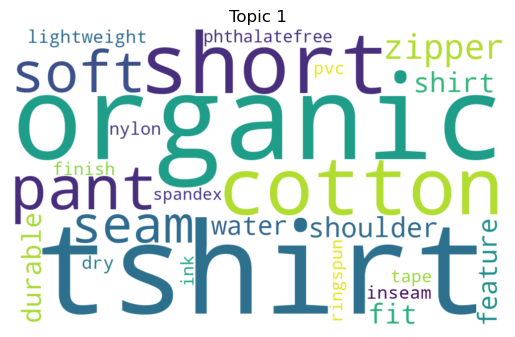

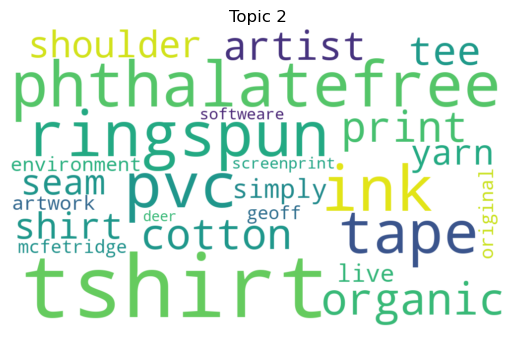

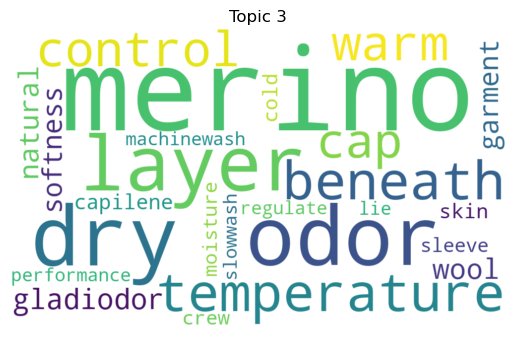

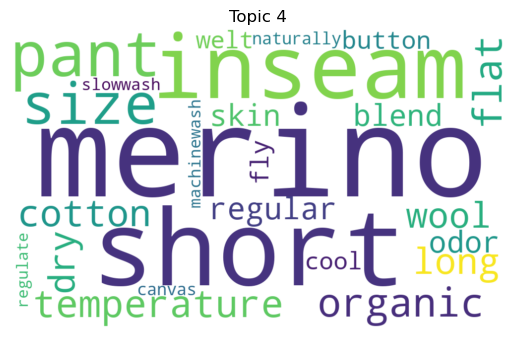

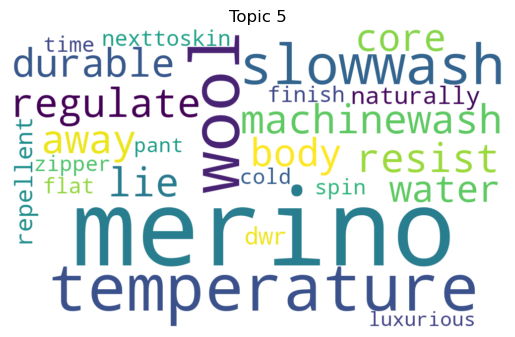

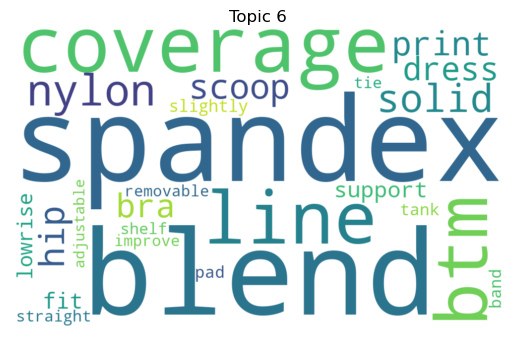

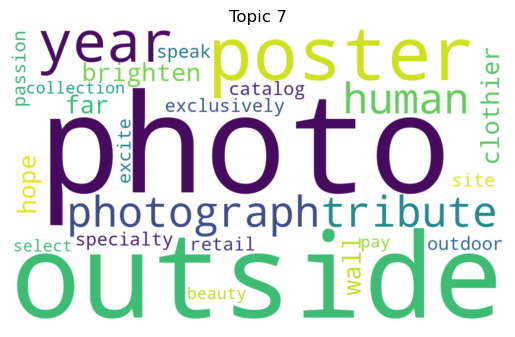

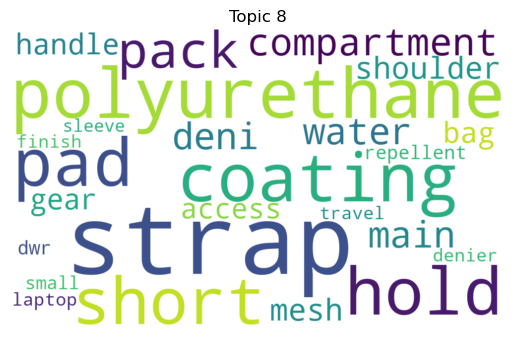

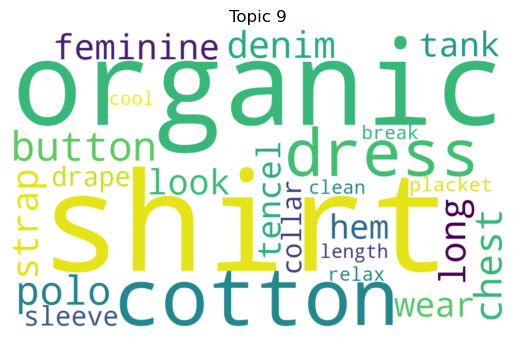

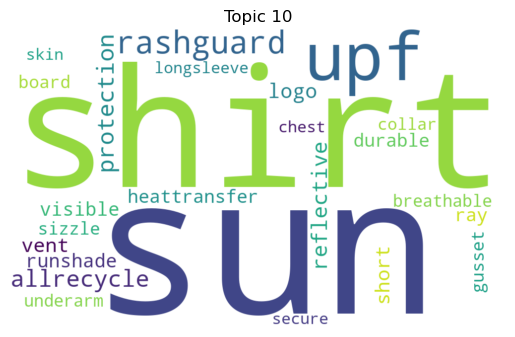

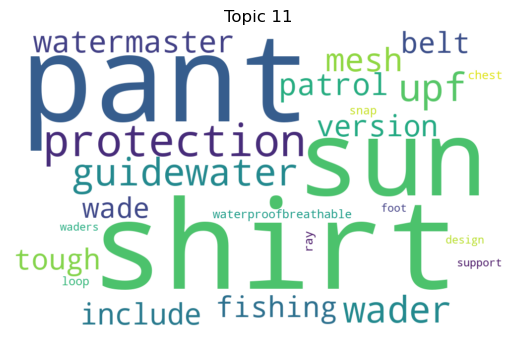

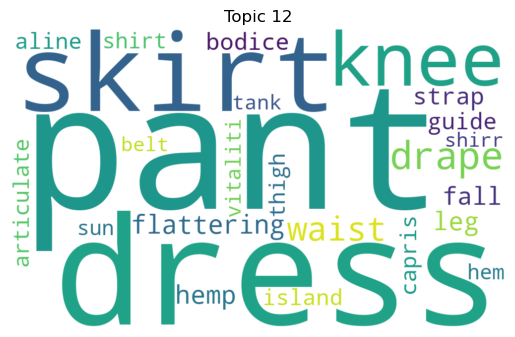

In [23]:
# Choose number of words to display
n_top_words=25

for i in range(n_components):
    topic_data = get_topic_words(i, n_top_words=n_top_words)

    wc = WordCloud(width=1000, height=600, background_color='white')
    wc.generate_from_frequencies(topic_data)

    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {i+1}")
    plt.show()